In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# !! IMPORTANT: Change "your_dataset_file.zip" to the exact name of your zip file
!unzip /content/drive/MyDrive/Images.zip -d /content/dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/2844747252_64567cf14a.jpg  
  inflating: /content/dataset/2844846111_8c1cbfc75d.jpg  
  inflating: /content/dataset/2844963839_ff09cdb81f.jpg  
  inflating: /content/dataset/2845246160_d0d1bbd6f0.jpg  
  inflating: /content/dataset/2845691057_d4ab89d889.jpg  
  inflating: /content/dataset/2845845721_d0bc113ff7.jpg  
  inflating: /content/dataset/2846037553_1a1de50709.jpg  
  inflating: /content/dataset/2846785268_904c5fcf9f.jpg  
  inflating: /content/dataset/2846843520_b0e6211478.jpg  
  inflating: /content/dataset/2847514745_9a35493023.jpg  
  inflating: /content/dataset/2847615962_c330bded6e.jpg  
  inflating: /content/dataset/2847859796_4d9cb0d31f.jpg  
  inflating: /content/dataset/2848266893_9693c66275.jpg  
  inflating: /content/dataset/2848571082_26454cb981.jpg  
  inflating: /content/dataset/2848895544_6d06210e9d.jpg  
  inflating: /content/dataset/2848977044_446a31d86e.jpg  
  inflating: /content

In [3]:
# !! IMPORTANT: Change "your_dataset_file.zip" to the exact name of your zip file
!unzip /content/drive/MyDrive/captions.txt.zip -d /content/dataset

Archive:  /content/drive/MyDrive/captions.txt.zip
  inflating: /content/dataset/captions.txt  


In [4]:
import os
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
from textwrap import wrap
import matplotlib.pyplot as plt

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Embedding, Dropout, Reshape,
                                     Bidirectional, LSTM, Concatenate, Layer,
                                     GlobalAveragePooling2D)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as effnet_preprocess

In [6]:
# The correct paths for Google Colab
data = pd.read_csv("/content/dataset/captions.txt")
image_path = "/content/dataset/Images"

In [7]:
def readImage(path, image_size=224):
    img = load_img(path, target_size=(image_size, image_size))
    img = img_to_array(img)
    img = effnet_preprocess(img)
    return img

In [8]:
def display_images(temp_df, image_path, image_size=224):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize=(15,15))
    n = 0
    for i in range(min(len(temp_df), 15)):
        n += 1
        plt.subplot(5,5,n)
        plt.subplots_adjust(hspace = 0.7, wspace= 0.3)
        image = readImage(os.path.join(image_path, temp_df['image'][i]), image_size=image_size)
        img_disp = (image - image.min()) / (image.max() - image.min())
        plt.imshow(img_disp.astype(np.float32))
        plt.title("\n".join(wrap(temp_df['caption'][i], 25)))
        plt.axis('off')
    plt.show()

In [9]:
# This is the probable correct path
image_path = "/content/dataset/flickr8k/Images"

In [10]:
# 1. Update the path for captions.txt (if you got the first error)
data = pd.read_csv("/content/dataset/captions.txt")

# 2. Update the image_path to point to the correct folder
# The images themselves are directly in /content/dataset, not in an 'Images' subfolder.
image_path = "/content/dataset"

In [11]:
print(data.head())

                       image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  


Image 1 Caption: Two brown and white dogs in the grass near a stone structure .
Image 2 Caption: A person in a black ninja costume playing a guitar .
Image 3 Caption: A child is holding up a camera in front of its face .
Image 4 Caption: The young girl in blue is having fun on a slide .
Image 5 Caption: Man with green shirt looks at phone .
Image 6 Caption: A large man is wearing a headband with mistletoe attached to it .
Image 7 Caption: A teenage boy doing a skateboard trick while another boy rides on a skateboard in the background .
Image 8 Caption: An elderly person with a brick wall int he background .
Image 9 Caption: An old man in a straw hat sits on a park bench .
Image 10 Caption: A man in a green swimsuit entering the water headfirst after jumping off a rock .
Image 11 Caption: A black and white dog catches a toy in midair .
Image 12 Caption: A close shot of a young swimmer sitting on the edge of a pool in front of others .
Image 13 Caption: A young boy is wearing khaki pants

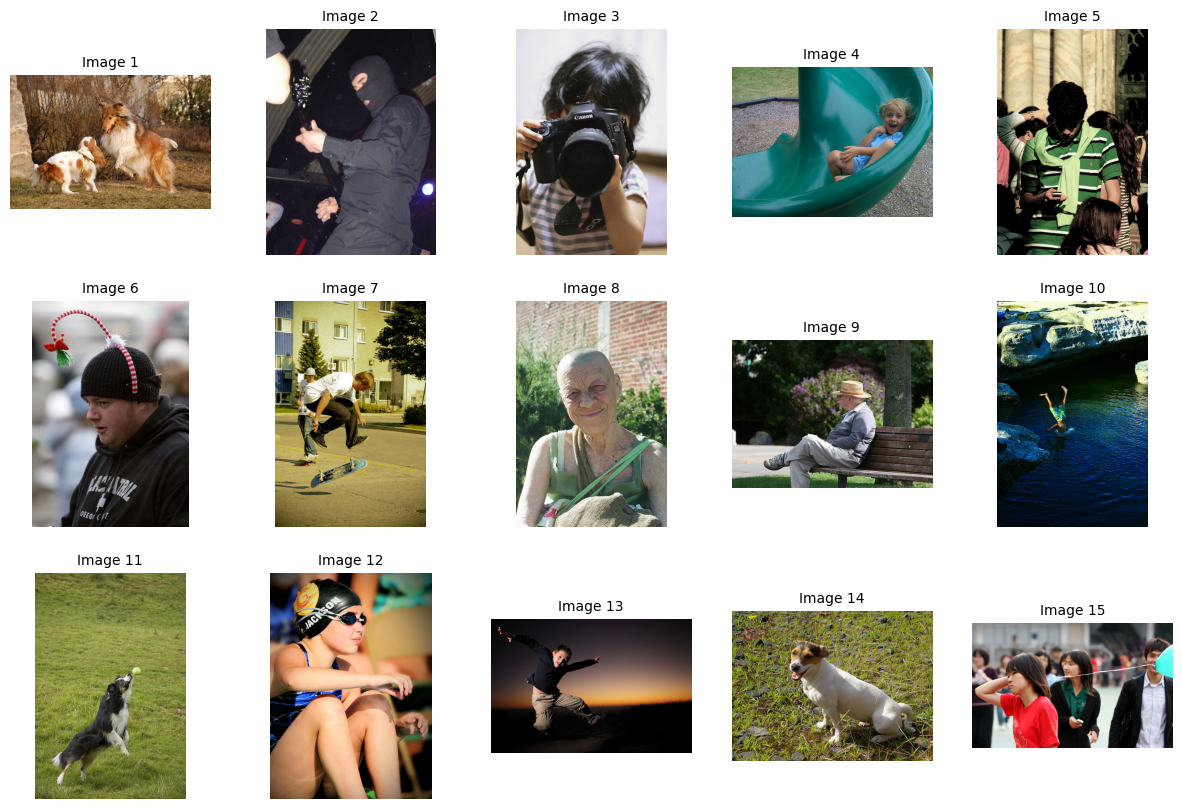

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os # We'll need this for joining paths

def display_images(sample_data, base_path):
    """
    Displays images and their captions from a DataFrame sample.
    Assumes the image filename is in a column named 'image'.
    """
    plt.figure(figsize=(15, 10))

    # 🚨 CRITICAL CHECK: Ensure this column name ('image') matches your DataFrame!
    if 'image' not in sample_data.columns:
        print("Error: DataFrame must have an 'image' column with the filename.")
        return

    for i, row in enumerate(sample_data.iterrows()):
        filename = row[1]['image']
        caption = row[1]['caption']

        # 🤝 Use os.path.join for robust path creation
        full_image_path = os.path.join(base_path, filename)

        try:
            plt.subplot(3, 5, i + 1) # 3 rows, 5 columns
            img = mpimg.imread(full_image_path)
            plt.imshow(img)
            plt.title(f"Image {i+1}", fontsize=10)
            plt.axis('off')

            # Optionally print the caption
            print(f"Image {i+1} Caption: {caption}")

        except FileNotFoundError:
            print(f"Error: Could not find image at path: {full_image_path}")
            # If the error is here, then the file is not in /content/dataset OR
            # the filename is still corrupt in the DataFrame (e.g., contains 'Images/')
        except Exception as e:
            print(f"An error occurred loading image {filename}: {e}")


# Re-run the function with the correct image_path
image_path = "/content/dataset"
display_images(data.sample(15), image_path)

Image 1 Caption: A medium sized white dog is jumping up to catch a small cloth Frisbee .
Image 2 Caption: Dog with a thick collar running through the grass
Image 3 Caption: A man sits outside in the snow with his dog and blue blanket .
Image 4 Caption: A black boy and white boy in swimming trunks are hugging each other on a beach or lake .
Image 5 Caption: Two children fall headfirst into a colorful ball pit while a third child watches .
Image 6 Caption: two children and their dog play in the snow .
Image 7 Caption: one grey puddle jumping in the air in front of another tan dog
Image 8 Caption: The girl is wearing headphones and holding a Michael Jackson album .
Image 9 Caption: Six Asian women dressed in pastels pose for a picture .
Image 10 Caption: A girl in a bikini swimming in a body of water .
Image 11 Caption: Many dogs are running the same way in a field .
Image 12 Caption: A dog hops in a field while another dog stands next to it .
Image 13 Caption: A woman in a wheelchair and

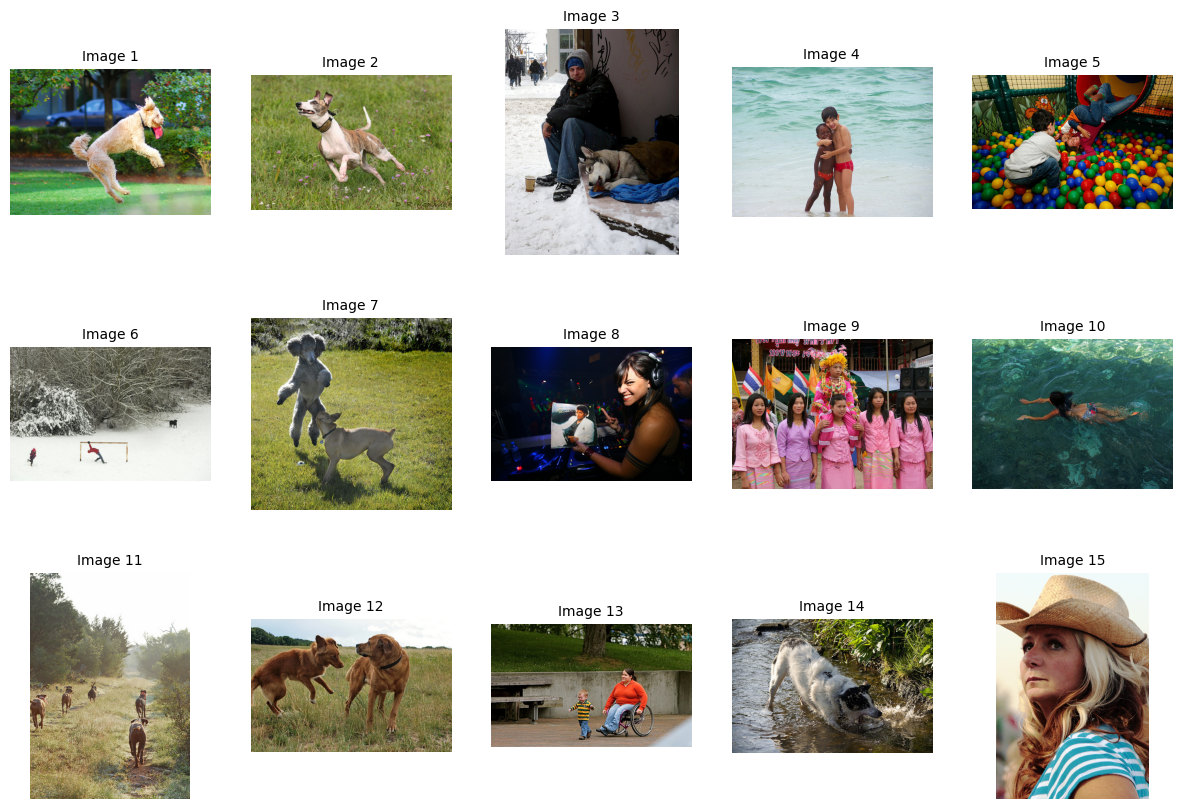

In [13]:
display_images(data.sample(15), image_path)

In [14]:
# This command lists everything inside your 'dataset' folder
!ls /content/dataset

# If you see 'flickr8k' in the list above, run this command too:
!ls /content/dataset/flickr8k

1000268201_693b08cb0e.jpg  2701603045_6cbdc4ce7c.jpg  3392019836_c7aeebca1c.jpg
1001773457_577c3a7d70.jpg  2701895972_8605c4e038.jpg  3392293702_ccb0599857.jpg
1002674143_1b742ab4b8.jpg  2702506716_17a7fb3ba4.jpg  3392851587_a638ff25e2.jpg
1003163366_44323f5815.jpg  270263570_3160f360d3.jpg   3393035454_2d2370ffd4.jpg
1007129816_e794419615.jpg  2703155733_19ac6f97a8.jpg  3393152604_27bd1037f2.jpg
1007320043_627395c3d8.jpg  2704257993_d485058a5f.jpg  3393343330_b13df4d8ec.jpg
1009434119_febe49276a.jpg  2704362232_7d84503433.jpg  3393394134_0caac47e1c.jpg
1012212859_01547e3f17.jpg  2704379125_9c35650d16.jpg  3393446245_37dd3f3b59.jpg
1015118661_980735411b.jpg  2704934519_457dc38986.jpg  339350939_6643bfb270.jpg
1015584366_dfcec3c85a.jpg  2705793985_007cc703fb.jpg  3393926562_66cc01b001.jpg
101654506_8eb26cfb60.jpg   2705947033_5999147842.jpg  3394070357_cb2a3243fc.jpg
101669240_b2d3e7f17b.jpg   2706023395_ac9eba0e42.jpg  3394586927_eae7732b64.jpg
1016887272_03199f49c4.jpg  2706430695_3b5

In [15]:
# 1. Update the path for captions.txt (if you got the first error)
data = pd.read_csv("/content/dataset/captions.txt")

# 2. Update the image_path to point to the correct folder
# The images themselves are directly in /content/dataset, not in an 'Images' subfolder.
image_path = "/content/dataset"

In [16]:
import re
def text_preprocessing(df, caption_col='caption'):
    df[caption_col] = df[caption_col].astype(str).str.strip()
    df[caption_col] = df[caption_col].str.lower()
    df[caption_col] = df[caption_col].apply(lambda x: re.sub(r"[^a-z0-9\s\.,'!?-]", "", x))
    df[caption_col] = df[caption_col].apply(lambda x: "startseq " + x.strip() + " endseq")
    return df

In [17]:
data = text_preprocessing(data)

In [18]:
data.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  startseq a child in a pink dress is climbing u...  
1  startseq a girl going into a wooden building ....  
2  startseq a little girl climbing into a wooden ...  
3  startseq a little girl climbing the stairs to ...  
4  startseq a little girl in a pink dress going i...

In [19]:
captions = data['caption'].tolist()

In [20]:
tokenizer = Tokenizer(oov_token=None)
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocab size: {vocab_size}")

Vocab size: 8496


In [21]:
max_length = max(len(c.split()) for c in captions)
print(f"Max caption length: {max_length}")

Max caption length: 40


In [22]:
images = data['image'].unique().tolist()
nimages = len(images)
print(f"Number of unique images: {nimages}")
split_index = round(nimages * 0.85)
train_images = images[:split_index]
val_images = images[split_index:]
train = data[data['image'].isin(train_images)].reset_index(drop=True)
val = data[data['image'].isin(val_images)].reset_index(drop=True)

Number of unique images: 8091


In [23]:
train

image  \
0      1000268201_693b08cb0e.jpg   
1      1000268201_693b08cb0e.jpg   
2      1000268201_693b08cb0e.jpg   
3      1000268201_693b08cb0e.jpg   
4      1000268201_693b08cb0e.jpg   
...                          ...   
34380  3688839836_ba5e4c24fc.jpg   
34381  3688839836_ba5e4c24fc.jpg   
34382  3688839836_ba5e4c24fc.jpg   
34383  3688839836_ba5e4c24fc.jpg   
34384  3688839836_ba5e4c24fc.jpg   

                                                 caption  
0      startseq a child in a pink dress is climbing u...  
1      startseq a girl going into a wooden building ....  
2      startseq a little girl climbing into a wooden ...  
3      startseq a little girl climbing the stairs to ...  
4      startseq a little girl in a pink dress going i...  
...                                                  ...  
34380  startseq a woman is holding out a peace sign d...  
34381  startseq a woman wearing a red scarf raises he...  
34382  startseq people in orange shirts marching down...  
34383  startseq the woman in the red shirt is holding...  
34384  startseq the woman is flashing a peace sign . ...  

[34385 rows x 2 columns]

In [24]:
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

In [25]:
img_size = 224

In [26]:
base_model = EfficientNetB0(weights='imagenet', include_top = False, input_shape = (img_size, img_size, 3))
fe_model = Model(inputs = base_model.input, outputs = base_model.output)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [27]:
import os
from tqdm import tqdm
from PIL import UnidentifiedImageError # Need this to catch corrupted files
import numpy as np

features = {}
image_list = data['image'].unique().tolist()

for i, image in enumerate(tqdm(image_list, desc="Extracting features")):

    full_path = os.path.join(image_path, image)

    try:
        # Attempt to read and process the image
        img = readImage(full_path, image_size=img_size)
        img = np.expand_dims(img, axis=0)

        # Check if the image loaded successfully (sometimes readImage returns None on failure)
        if img is None:
            # This handles cases where readImage fails silently or returns an unreadable format
            raise UnidentifiedImageError(f"Image read failure for {image}")

        feat_map = fe_model.predict(img, verbose=0)
        feat_map = feat_map[0]
        h, w, c = feat_map.shape
        feat_reshaped = feat_map.reshape(-1, c)
        features[image] = feat_reshaped.astype(np.float32)

    except (UnidentifiedImageError, FileNotFoundError) as e:
        # 🎯 CATCH BOTH ERRORS:
        # 1. UnidentifiedImageError (for corrupted files like the one you just skipped)
        # 2. FileNotFoundError (for missing files like the current one)
        print(f"\n[SKIP] Failed to process {image}. Reason: {type(e).__name__}. Skipping...")
        continue # Skip this file and move to the next iteration

    except Exception as e:
        # Re-raise any other truly unexpected, fatal error (e.g., memory, hardware)
        print(f"\n[FATAL ERROR] An unexpected, unhandled error occurred on {image}: {e}")
        raise e

print("\nFeature extraction complete (skipped corrupted or missing images).")

Extracting features: 100%|██████████| 8091/8091 [10:44<00:00, 12.55it/s]


Feature extraction complete (skipped corrupted or missing images).


In [28]:
sample_feature = next(iter(features.values()))
num_patches, feat_dim = sample_feature.shape
print("num_patches:", num_patches, "feat_dim:", feat_dim)

num_patches: 49 feat_dim: 1280


In [29]:
with open("features_effnetb7.pkl", "wb") as f:
    pickle.dump(features, f)

In [30]:
with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

In [31]:
with open("features_effnetb7.pkl", "rb") as f:
    features = pickle.load(f)

In [32]:
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

class CustomDataGenerator(Sequence):
    def __init__(self, df, X_col, y_col, batch_size, tokenizer, vocab_size, max_length, features_dict, shuffle=True):
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features_dict
        self.shuffle = shuffle
        self.n = len(self.df)
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return int(np.ceil(self.n / float(self.batch_size)))

    @property
    def num_batches(self):
        return self.__len__()

    def __getitem__(self, index):
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size, :]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self, batch):
        X1, X2, y = [], [], []
        images = batch[self.X_col].unique().tolist()

        for _, row in batch.iterrows():
            image = row[self.X_col]
            caption = row[self.y_col]
            feature = self.features[image]
            seq = self.tokenizer.texts_to_sequences([caption])[0]

            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                in_seq = pad_sequences([in_seq], maxlen=self.max_length, padding='post')[0]
                out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                X1.append(feature)
                X2.append(in_seq)
                y.append(out_seq)

        X1 = np.array(X1)
        X2 = np.array(X2)
        y = np.array(y)
        return X1, X2, y


In [33]:
class BahdanauAttention(Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V  = Dense(1)

    def call(self, encoder_features, decoder_hidden):
        decoder_hidden_with_time_axis = tf.expand_dims(decoder_hidden, 1)
        score = tf.nn.tanh(self.W1(encoder_features) + self.W2(decoder_hidden_with_time_axis))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * encoder_features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, tf.squeeze(attention_weights, -1)
        return context_vector, tf.squeeze(attention_weights, -1)

In [34]:
num_patches = sample_feature.shape[0]
feat_dim = sample_feature.shape[1]

In [35]:
encoder_input = Input(shape=(num_patches, feat_dim), name='image_features')
decoder_input = Input(shape=(max_length,), name='decoder_input')

In [36]:
embedding_dim = 512
embed = Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True, name='embed')(decoder_input)

In [37]:
bi_lstm = Bidirectional(LSTM(512, return_sequences=False, return_state=False), name='bilstm')(embed)

In [38]:
attention_units = 512
attention = BahdanauAttention(attention_units)
context_vector, att_weights = attention(encoder_input, bi_lstm)

In [39]:
concat = Concatenate(axis=-1)([context_vector, bi_lstm])  # (batch, feat_dim + 1024)
x = Dense(512, activation='relu')(concat)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(vocab_size, activation='softmax')(x)

In [40]:
caption_model = Model(inputs=[encoder_input, decoder_input], outputs=outputs)
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')
caption_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ decoder_input       │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embed (Embedding)   │ (None, 40, 512)   │  4,349,952 │ decoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 40)        │          0 │ decoder_input[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_features      │ (None, 49, 1280)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm              │ (None, 1024)      │  4,198,400 │ embed[0][0],      │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bahdanau_attention  │ [(None, 1280),    │  1,181,185 │ image_features[0… │
│ (BahdanauAttention) │ (None, 49)]       │            │ bilstm[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2304)      │          0 │ bahdanau_attenti… │
│ (Concatenate)       │                   │            │ bilstm[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 512)       │  1,180,160 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │    131,328 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 8496)      │  2,183,472 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,224,497 (50.45 MB)

 Trainable params: 13,224,497 (50.45 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
batch_size = 32

train_generator = CustomDataGenerator(
    df=train,
    X_col='image',
    y_col='caption',
    batch_size=batch_size,
    tokenizer=tokenizer,
    vocab_size=vocab_size,
    max_length=max_length,
    features_dict=features,
    shuffle=True
)

validation_generator = CustomDataGenerator(
    df=val,
    X_col='image',
    y_col='caption',
    batch_size=batch_size,
    tokenizer=tokenizer,
    vocab_size=vocab_size,
    max_length=max_length,
    features_dict=features,
    shuffle=False
)


In [42]:
model_name = "caption_trained_model.h5"
checkpoint = ModelCheckpoint(model_name, monitor="val_loss", mode="min", save_best_only=True, verbose=1)
earlystopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, min_lr=1e-9, verbose=1)

In [43]:
 # Example features keys: "2097398349_ff178b3f1b"
train['image'] = train['image'].str.replace('.jpg', '', regex=False)


In [44]:
# Example features keys: "2097398349_ff178b3f1b"
features = {k.replace('.jpg', ''): v for k, v in features.items()}


In [45]:
missing = [img for img in train['image'].unique() if img not in features]
print("Missing features:", len(missing))


Missing features: 0


In [46]:
train['image'].head(10).tolist()


['1000268201_693b08cb0e',
 '1000268201_693b08cb0e',
 '1000268201_693b08cb0e',
 '1000268201_693b08cb0e',
 '1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1001773457_577c3a7d70',
 '1001773457_577c3a7d70',
 '1001773457_577c3a7d70',
 '1001773457_577c3a7d70']

In [47]:
train['image'] = train['image'].apply(lambda x: x.split('/')[-1])


In [48]:
train['image'] = train['image'].apply(lambda x: x if x.endswith('.jpg') else x + '.jpg')


In [49]:
train['image'] = train['image'].str.strip()


In [50]:
missing = [img for img in train['image'].unique() if img not in features]
print("Missing features:", len(missing))


Missing features: 6877


In [51]:
train['image'] = train['image'].apply(lambda x: x + '.jpg' if not x.endswith('.jpg') else x)
val['image'] = val['image'].apply(lambda x: x + '.jpg' if not x.endswith('.jpg') else x)


In [52]:
missing = [img for img in train['image'].unique() if img not in features]
print("Missing features:", len(missing))


Missing features: 6877


In [53]:
print("Example from train['image']:", train['image'].iloc[0])
print("Example key from features:", list(features.keys())[0])


Example from train['image']: 1000268201_693b08cb0e.jpg
Example key from features: 1000268201_693b08cb0e


In [54]:
features = {k + '.jpg': v for k, v in features.items()}


In [55]:
missing = [img for img in train['image'].unique() if img not in features]
print("Missing features:", len(missing))


Missing features: 0


In [56]:
history = caption_model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[checkpoint, earlystopping, reduce_lr],
    verbose=1
)


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1075/1075 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 4.7555
Epoch 1: val_loss improved from inf to 3.50843, saving model to caption_trained_model.h5


1075/1075 ━━━━━━━━━━━━━━━━━━━━ 196s 177ms/step - loss: 4.7550 - val_loss: 3.5084 - learning_rate: 0.0010
Epoch 2/10
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 3.4626
Epoch 2: val_loss improved from 3.50843 to 3.24895, saving model to caption_trained_model.h5


1075/1075 ━━━━━━━━━━━━━━━━━━━━ 174s 162ms/step - loss: 3.4625 - val_loss: 3.2490 - learning_rate: 0.0010
Epoch 3/10
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 3.1683
Epoch 3: val_loss improved from 3.24895 to 3.13553, saving model to caption_trained_model.h5


1075/1075 ━━━━━━━━━━━━━━━━━━━━ 203s 188ms/step - loss: 3.1683 - val_loss: 3.1355 - learning_rate: 0.0010
Epoch 4/10
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 2.9781
Epoch 4: val_loss improved from 3.13553 to 3.09389, saving model to caption_trained_model.h5


1075/1075 ━━━━━━━━━━━━━━━━━━━━ 186s 173ms/step - loss: 2.9781 - val_loss: 3.0939 - learning_rate: 0.0010
Epoch 5/10
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 2.8292
Epoch 5: val_loss improved from 3.09389 to 3.07794, saving model to caption_trained_model.h5


1075/1075 ━━━━━━━━━━━━━━━━━━━━ 219s 189ms/step - loss: 2.8292 - val_loss: 3.0779 - learning_rate: 0.0010
Epoch 6/10
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 2.7275
Epoch 6: val_loss improved from 3.07794 to 3.06106, saving model to caption_trained_model.h5


1075/1075 ━━━━━━━━━━━━━━━━━━━━ 171s 159ms/step - loss: 2.7275 - val_loss: 3.0611 - learning_rate: 0.0010
Epoch 7/10
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 2.6173
Epoch 7: val_loss did not improve from 3.06106
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 191s 177ms/step - loss: 2.6173 - val_loss: 3.0840 - learning_rate: 0.0010
Epoch 8/10
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 2.5423
Epoch 8: val_loss did not improve from 3.06106
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 189s 175ms/step - loss: 2.5423 - val_loss: 3.1004 - learning_rate: 0.0010
Epoch 9/10
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 2.4736
Epoch 9: val_loss did not improve from 3.06106

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 195s 182ms/step - loss: 2.4736 - val_loss: 3.1338 - learning_rate: 0.0010
Epoch 10/10
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 2.3368
Epoch 10: val_loss did not improve from 3.06106
1075/1075 ━━━━━━━━━━━━━━━━━━

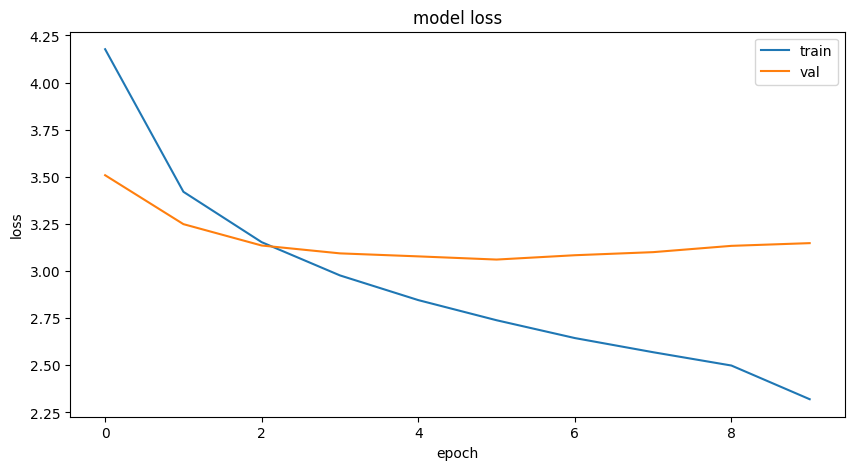

In [57]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [58]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [59]:
def clean_caption(raw_caption):
    caption = raw_caption.replace('startseq', '').replace('endseq', '').strip()
    caption = caption.capitalize()
    if not caption.endswith('.'):
        caption = caption + '.'
    return caption

In [60]:
import math
def beam_search_predictions(model, tokenizer, feature, max_length, beam_index=3):
    start_token = tokenizer.word_index.get('startseq')
    end_token = tokenizer.word_index.get('endseq')
    if start_token is None or end_token is None:
        raise ValueError("startseq/endseq tokens missing in tokenizer")
    sequences = [[ [start_token], 0.0 ]]

    while True:
        all_candidates = []
        for seq, score in sequences:
            if seq[-1] == end_token or len(seq) >= max_length:
                all_candidates.append((seq, score))
                continue
            sequence = pad_sequences([seq], maxlen=max_length, padding='post')
            yhat = model.predict([feature[np.newaxis,...], sequence], verbose=0)[0]
            top_indices = np.argsort(yhat)[-beam_index:]
            for idx in top_indices:
                prob = yhat[idx]
                if prob <= 0:
                    continue
                candidate_seq = seq + [int(idx)]
                candidate_score = score + math.log(prob + 1e-10)
                all_candidates.append((candidate_seq, candidate_score))
        ordered = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)
        sequences = ordered[:beam_index]

        if any(s[-1] == end_token for s, _ in sequences):
            break
        if len(sequences[0][0]) >= max_length:
            break


    best_seq = sequences[0][0]

    words = [idx_to_word(i, tokenizer) for i in best_seq]

    caption = " ".join([w for w in words if w is not None])
    return clean_caption(caption)

def predict_caption_beam(model, image_key, tokenizer, max_length, features_dict, beam_index=3):
    feature = features_dict[image_key]
    return beam_search_predictions(model, tokenizer, feature, max_length, beam_index=beam_index)

In [61]:
test_img = val.iloc[0]['image']
test_pred = predict_caption_beam(caption_model, test_img, tokenizer, max_length, features, beam_index=3)
print(type(test_pred))
print(test_pred)


<class 'str'>
A woman in a white dress is standing in front of a group of people.


In [62]:
val['image'] = val['image'].astype(str)


Image 1 Caption: A brown dog is running in a grassy area.
Image 2 Caption: A brown dog is playing with a tennis ball.
Image 3 Caption: A boy in a red shirt is running through the grass.
Image 4 Caption: A group of children are playing on rocks.
Image 5 Caption: Two dogs are running through a field.
Image 6 Caption: A group of people in a parade.
Image 7 Caption: A young boy in a red shirt and white shorts jumps over a red ball.
Image 8 Caption: A man in a white shirt and white shorts is running on a dirt path.
Image 9 Caption: A black and white dog is playing with a ball in.
Image 10 Caption: A little boy in a red shirt is playing with a little boy.
Image 11 Caption: Two girls are playing in a grassy field.
Image 12 Caption: A woman in a white shirt is sitting on the street.


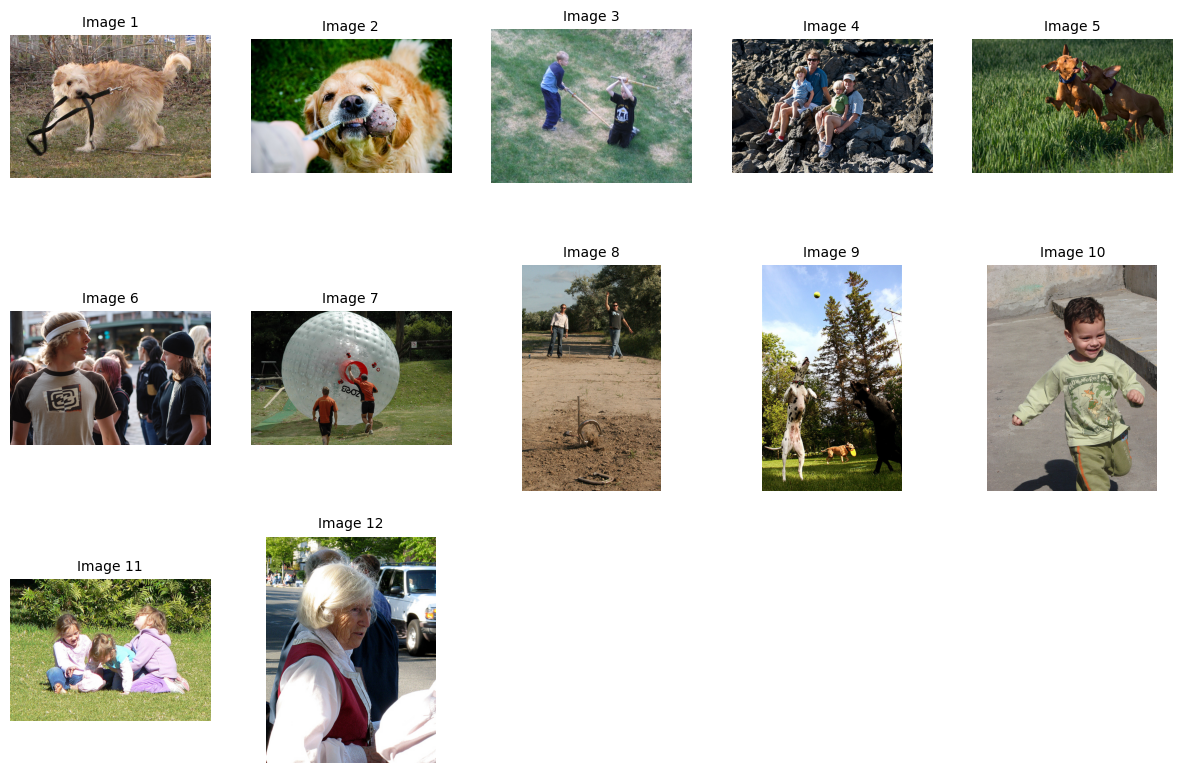

In [64]:
samples = val.sample(12).reset_index(drop=True)
for idx, row in samples.iterrows():
    pred = predict_caption_beam(caption_model, row['image'], tokenizer, max_length, features, beam_index=3)
    samples.at[idx, 'caption'] = pred

display_images(samples, image_path)

## 🖼️ Image Upload and Caption Display Fix

In [65]:

# Step 1: Upload image file
from google.colab import files
uploaded = files.upload()


Saving p1.PNG to p1.PNG


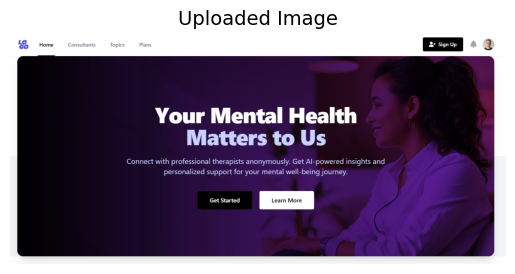

In [66]:

# Step 2: Display uploaded image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Automatically get the uploaded file name
image_path = list(uploaded.keys())[0]

if os.path.exists(image_path):
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Uploaded Image", fontsize=14)
    plt.show()
else:
    print("❌ Image not found. Please upload again.")


In [69]:
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

def generate_caption(image_path):
    raw_image = Image.open(image_path).convert("RGB")
    inputs = processor(raw_image, return_tensors="pt").to(device)
    out = model.generate(**inputs)
    return processor.decode(out[0], skip_special_tokens=True)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [70]:

# Step 3: Combine with Caption Generation (assuming you have generate_caption() defined)

# Example caption generation call
# Replace this function call with your actual caption model inference
try:
    caption = generate_caption(image_path)  # <-- your model function here
    print("📝 Caption:", caption)
except NameError:
    print("⚠️ Please define your 'generate_caption(image_path)' function above.")


📝 Caption: the website for mental health


In [71]:

# Step 4: Check files if image not found
import os
print("Current directory:", os.getcwd())
print("Files available:", os.listdir())


Current directory: /content
Files available: ['.config', 'dataset', 'drive', 'caption_trained_model.h5', 'p1.PNG', 'features_effnetb7.pkl', 'tokenizer.pkl', 'sample_data']


In [76]:
import os
print("Current directory:", os.getcwd())
print("Files here:", os.listdir())


Current directory: /content
Files here: ['.config', 'dataset', 'drive', 'caption_trained_model.h5', 'p1.PNG', 'features_effnetb7.pkl', 'tokenizer.pkl', 'sample_data']


In [ ]:
from google.colab import files

uploaded = files.upload()


In [75]:
import nbformat

input_path = "Untitled3_fixed.ipynb"      # your notebook
output_path = "Untitled3_fixed_clean.ipynb"

with open(input_path, "r", encoding="utf-8") as f:
    nb = nbformat.read(f, as_version=4)

# safely remove problematic metadata
if "widgets" in nb.metadata:
    del nb.metadata["widgets"]

# also clean per-cell widget leftovers
for cell in nb.cells:
    if "metadata" in cell and "widgets" in cell["metadata"]:
        del cell["metadata"]["widgets"]

with open(output_path, "w", encoding="utf-8") as f:
    nbformat.write(nb, f)

print("✅ Cleaned notebook saved as", output_path)


FileNotFoundError: [Errno 2] No such file or directory: 'Untitled3_fixed.ipynb'